# Notebook Data & AI Fast Track
## Notebook 1 - Utilizando as bibliotecas de ADS, AutoML de Publicando o modelo em Produção
### Para executar os comandos contidos em cada célula, é necessário colocar o cursor na célula e pressionar no teclado "Ctrl + Enter"

#### Vamos ajustar a versão da biblioteca ADS

In [ ]:
!pip install oracle-ads==2.5.9
!pip install -U oci

#### Agora é hora de carregar na memória a maioria das bibliotecas e funções que serão utilizadas neste script

In [1]:
def algo_selec(model):
    trials = model.model_selection_trials_
    fig, ax = plt.subplots(1)
    colors = []
    scores = [x[3] for x in trials]
    models = [x[0] for x in trials]
    y_margin = 0.10 * (max(scores) - min(scores))
    s = pd.Series(scores, index=models).sort_values(ascending=False)
    ax.set_title("Algorithm Selection Trials")
    for f in s.keys():
        if f == '{}_AS'.format(est_pred.selected_model_):
            colors.append('orange')
        elif s[f] >= s.mean():
            colors.append('teal')
        else:
            colors.append('turquoise')
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    s.plot.bar(ax=ax, color=colors, edgecolor='black')
    ax.axhline(y=s.mean(), color='black', linewidth=0.5)
    return(plt.show())

def adap_sample(model):
    trials = model.adaptive_sampling_trials_
    fig, ax = plt.subplots(1)
    ax.set_title("Adaptive Sampling ({})".format(trials[0][0]))
    ax.set_xlabel('Dataset sample size')
    ax.set_ylabel(r"Predicted model score")
    scores = [x[3] for x in trials]
    n_samples = [x[1] for x in trials]
    y_margin = 0.10 * (max(scores) - min(scores))
    ax.grid(color='g', linestyle='-', linewidth=0.1)
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
    return(plt.show())

def feat_selec(model):
    trials = model.feature_selection_trials_
    fig, ax = plt.subplots(1)
    ax.set_title("Feature Selection Trials")
    ax.set_xlabel("Number of Features")
    ax.set_ylabel(r"Predicted model score")
    scores = [x[3] for x in trials]
    n_features = [x[2] for x in trials]
    y_margin = 0.10 * (max(scores) - min(scores))
    ax.grid(color='g', linestyle='-', linewidth=0.1)
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
    ax.axvline(x=len(model.selected_features_names_), color='orange', linewidth=2.0)
    return(plt.show())

def hyper_tuning(model):
    trials = model.tuning_trials_
    fig, ax = plt.subplots(1)
    ax.set_title("Hyperparameter Tuning Trials")
    ax.set_xlabel("Iteration $n$")
    ax.set_ylabel(r"Computer model score")
    scores = [x[3] for x in reversed(trials)]
    y_margin = 0.10 * (max(scores) - min(scores))
    ax.grid(color='g', linestyle='-', linewidth=0.1)
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    ax.plot(range(1, len(trials) + 1), scores, 'k:', marker="s", color='teal', markersize=3)
    return(plt.show())

In [2]:
%matplotlib inline

import io
import tempfile
import uuid
import ads
import mlx
import oci
import logging
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os

import seaborn as sn
import automl
plt.style.use('ggplot')

from os import path
from ads.common import auth as authutil
from ads.dataset.factory import DatasetFactory
from ads import set_documentation_mode
from ads import set_auth
from ads.dataflow.dataflow import DataFlow
from ads.common.model import ADSModel
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.common.data import ADSData
from ads.evaluations.evaluator import ADSEvaluator
from ads.catalog.model import ModelCatalog
from ads.common.model import ADSModel
from ads.model.deployment import ModelDeployer, ModelDeploymentProperties
from ads.common.model_export_util import prepare_generic_model
from ads.evaluations.evaluator import ADSEvaluator
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from automl import Pipeline, init
from ads.model.deployment import ModelDeployer, ModelDeploymentProperties
from ads.common.model_export_util import prepare_generic_model
from oci.data_science import DataScienceClient, DataScienceClientCompositeOperations
from oci.auth.signers import get_resource_principals_signer
from oci.data_science.models import ModelConfigurationDetails, InstanceConfiguration, \
                                    FixedSizeScalingPolicy, CategoryLogDetails, LogDetails, \
                                    SingleModelDeploymentConfigurationDetails, CreateModelDeploymentDetails
from ads.database import connection 
from ads.database.connection import Connector
from ads.dataset.factory import DatasetFactory
from ads.vault.vault import Vault
from ads.common.oci_logging import OCILogGroup
from ads.common.auth import default_signer
from mlx import PermutationImportance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sqlalchemy import create_engine
from urllib.request import urlopen

ads.set_auth(auth="resource_principal")
set_documentation_mode(False)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

#### É possível acessar o conjunto de dados diretamente do Git

In [ ]:
df_listings = pd.read_csv("https://raw.githubusercontent.com/rafaelrdias/HapVida/main/Arquivos/listings_summary.csv")

#### Puxando a informação direto do banco de dados, substituir os valores abaixo pelos da HapVida, se e somente se o conjunto de dados que consta no arquivo listings_summary.csv foi carregado num Autonomous Database da HapVida

In [ ]:
connection_parameters = {
    "user_name": "Admin",
    "password": "XXXXXXXXXXX",
    "service_name": "bdtestes_medium",
    "wallet_location": "Wallet_bdtestes.zip",
}

In [ ]:
%%time
df = pd.DataFrame.ads.read_sql(
    "SELECT * FROM ADMIN.LISTINGS_SUMMARY",
    connection_parameters=connection_parameters,
)

In [ ]:
%%time
df_listings = DatasetFactory.open(df)

#### O arquivo com o conjunto de dados de locação de imóveis pode ser acessado através de conexão com um Object Storage -> Neste caso o arquivo listings_summary.csv deverá estar num bucket no ambiente da HapVida

#### **** Importante: Será necessário trocar o nome do "namespace" contido entre aspas, para tanto:
#### - Acessar o menu de hamburguer, clicar em "Storage" e após em "Bucket"
#### - Na próxima tela, copiar o nome e após clicar no bucket "YYYYYYYYY", isto abrirá uma nova tela, e então, copiar o código contido em "Namespace:" (o código contem letras e números)
#### - Colar as respectivas informações no lugar dos Y e X para "bucket_name" e "namespace"

In [3]:
from ads.common.auth import default_signer

bucket_name = "YYYYYYYYY"
namespace = 'XXXXXXXXX'
file_name = 'listings_summary.csv'

df_listings = DatasetFactory.open(f"oci://{bucket_name}@{namespace}/{file_name}", storage_options=default_signer(),format='csv', orient='records')


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

#### A função "show_in_notebook" mostra um resumo completo sobre o dataset

In [ ]:
df_listings.show_in_notebook()

#### Aqui serão eliminados algumas colunas que não são interessantes para o processo de modelagem

In [4]:
df_list_features = df_listings.drop_columns(['CALENDAR_LAST_SCRAPED', 'REVIEW_SCORES_ACCURACY', 'REVIEW_SCORES_CLEANLINESS', 'REVIEW_SCORES_CHECKIN',
'REVIEW_SCORES_COMMUNICATION', 'REVIEW_SCORES_LOCATION','REVIEW_SCORES_VALUE','FIRST_REVIEW', 'LAST_REVIEW', 'LICENSE','JURISDICTION_NAMES', 
'INSTANT_BOOKABLE', 'IS_BUSINESS_TRAVEL_READY','CANCELLATION_POLICY', 'ID', 'LISTING_URL', 'SCRAPE_ID', 'LAST_SCRAPED','NAME', 'THUMBNAIL_URL', 
'MEDIUM_URL', 'PICTURE_URL', 'XL_PICTURE_URL','HOST_ID', 'HOST_URL', 'HOST_NAME', 'HOST_SINCE', 'HOST_LOCATION','HOST_RESPONSE_TIME', 
'HOST_RESPONSE_RATE', 'HOST_ACCEPTANCE_RATE', 'HOST_THUMBNAIL_URL', 'HOST_NEIGHBOURHOOD','STREET', 'NEIGHBOURHOOD', 'CITY', 'STATE', 'ZIPCODE', 
'MARKET','SMART_LOCATION', 'COUNTRY_CODE', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'AMENITIES', 'PROPERTY_TYPE', 'ROOM_TYPE', 'ACCOMMODATES',
'WEEKLY_PRICE', 'MONTHLY_PRICE', 'NEIGHBOURHOOD_CLEANSED','BED_TYPE','NEIGHBOURHOOD_GROUP_CLEANSED', 'SECURITY_DEPOSIT', 'CALENDAR_UPDATED',
'HAS_AVAILABILITY', 'AVAILABILITY_30','HOST_VERIFICATIONS', 'SQUARE_FEET']).to_pandas_dataframe()

#### Validando as Variáveis

In [5]:
df_list_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17145 entries, 0 to 17144
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AVAILABILITY_60                   17144 non-null  float64
 1   AVAILABILITY_90                   17144 non-null  float64
 2   AVAILABILITY_365                  17144 non-null  float64
 3   NUMBER_OF_REVIEWS                 17144 non-null  float64
 4   REVIEW_SCORES_RATING              13897 non-null  float64
 5   REQUIRES_LICENSE                  17144 non-null  object 
 6   REQUIRE_GUEST_PROFILE_PICTURE     17144 non-null  object 
 7   REQUIRE_GUEST_PHONE_VERIFICATION  17144 non-null  object 
 8   CALCULATED_HOST_LISTINGS_COUNT    17144 non-null  float64
 9   REVIEWS_PER_MONTH                 14273 non-null  float64
 10  HOST_IS_SUPERHOST                 17136 non-null  object 
 11  HOST_LISTINGS_COUNT               17136 non-null  float64
 12  HOST

In [6]:
df_list_features[['PRICE','CLEANING_FEE','EXTRA_PEOPLE']]

PRICE CLEANING_FEE EXTRA_PEOPLE
0      $55.00        $5.00       $15.00 
1      $30.00       $20.00       $20.00 
2      $65.00       $30.00       $15.00 
3      $80.00      $100.00       $10.00 
4      $60.00       $60.00        $0.00 
...        ...          ...          ...
17140  $35.00       $90.00        $0.00 
17141  $48.00           NaN       $0.00 
17142  $40.00       $10.00       $20.00 
17143  $30.00           NaN       $0.00 
17144  $45.00           NaN       $0.00 

[17145 rows x 3 columns]

#### Ajuste das variáveis monetárias para correta compreensão dos algoritmos de ML

In [7]:
df_list_features['PRICE'] = df_list_features['PRICE'].str.replace('$','')
df_list_features['PRICE'] = df_list_features['PRICE'].str.replace(',','')
df_list_features['CLEANING_FEE'] = df_list_features['CLEANING_FEE'].str.replace('$','')
df_list_features['CLEANING_FEE'] = df_list_features['CLEANING_FEE'].str.replace(',','')
df_list_features['EXTRA_PEOPLE'] = df_list_features['EXTRA_PEOPLE'].str.replace('$','')
df_list_features['EXTRA_PEOPLE'] = df_list_features['EXTRA_PEOPLE'].str.replace(',','')

In [8]:
df_list_features[['PRICE','CLEANING_FEE','EXTRA_PEOPLE']] = df_list_features[['PRICE','CLEANING_FEE','EXTRA_PEOPLE']].astype('float64')
df_list_features[['PRICE','CLEANING_FEE','EXTRA_PEOPLE']].describe()

PRICE  CLEANING_FEE  EXTRA_PEOPLE
count  17144.000000  12067.000000  17144.000000
mean      69.353243     26.037955      8.520415
std      235.589547     25.276706     11.456552
min        0.000000      0.000000      0.000000
25%       32.000000     10.000000      0.000000
50%       48.000000     20.000000      5.000000
75%       70.000000     35.000000     15.000000
max     8600.000000    450.000000    250.000000

#### Ajuste das variáveis binárias para correta compreensão dos algoritmos de ML

In [9]:
df_list_features['REQUIRES_LICENSE']=df_list_features['REQUIRES_LICENSE'].replace(['t','f'],[1,0])
df_list_features['REQUIRE_GUEST_PROFILE_PICTURE']=df_list_features['REQUIRE_GUEST_PROFILE_PICTURE'].replace(['t','f'],[1,0])
df_list_features['REQUIRE_GUEST_PHONE_VERIFICATION']=df_list_features['REQUIRE_GUEST_PHONE_VERIFICATION'].replace(['t','f'],[1,0])
df_list_features['HOST_IS_SUPERHOST']=df_list_features['HOST_IS_SUPERHOST'].replace(['t','f'],[1,0])
df_list_features['HOST_HAS_PROFILE_PIC']=df_list_features['HOST_HAS_PROFILE_PIC'].replace(['t','f'],[1,0])
df_list_features['HOST_IDENTITY_VERIFIED']=df_list_features['HOST_IDENTITY_VERIFIED'].replace(['t','f'],[1,0])
df_list_features['IS_LOCATION_EXACT']=df_list_features['IS_LOCATION_EXACT'].replace(['t','f'],[1,0])

In [10]:
df_list_features[['REQUIRES_LICENSE','REQUIRE_GUEST_PROFILE_PICTURE','REQUIRE_GUEST_PHONE_VERIFICATION','HOST_IS_SUPERHOST','HOST_HAS_PROFILE_PIC','HOST_IDENTITY_VERIFIED','IS_LOCATION_EXACT']]=df_list_features[['HOST_IS_SUPERHOST','REQUIRES_LICENSE','REQUIRE_GUEST_PROFILE_PICTURE','REQUIRE_GUEST_PHONE_VERIFICATION','HOST_HAS_PROFILE_PIC','HOST_IDENTITY_VERIFIED','IS_LOCATION_EXACT']].astype('float64')

In [11]:
df_list_features = DatasetFactory.open(df_list_features)
df_list_features = df_list_features.set_target('PRICE')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

### Após ajustes iremos utilizar a função "get_recommendations()" do ADS para verificar se existe mais correções ou transformações no dataframe

#### Aparecerá um quadro chamado "Imputation", selecionar "Fill missing values with constant" para todas as variáveis, após clicar em "Next"

#### Após aparecerá um quadro chamado "Multicollinear Columns", basta clicar em "Next" e após em "Apply"

In [12]:
df_list_features.get_recommendations()

Output()

#### Abaixo salvaremos as alterações realizadas anteriormente

In [13]:
df_list_adjusted = df_list_features.get_transformed_dataset()

#### ---------------------------------------------------------------------------------------------
## Exemplo de execução de DataFlow lendo todos os arquivos ORCs em um object storage

##### Célula de autenticação

#### Autenticação utilizando as policies de IAM


In [14]:
ads.set_auth(auth="resource_principal")

#### crianção de diretorio temporário

In [15]:
dataflow_base_folder = tempfile.mkdtemp()

#### Célula de autenticação no Dataflow

#### criando estrutura de autenticação no dataflow


In [16]:
data_flow = DataFlow(dataflow_base_folder=dataflow_base_folder, 
                     os_auth=authutil.resource_principal({"timeout": 60000}), 
                     df_auth=authutil.resource_principal({"timeout": 60000}))
print("Data flow directory: {}".format(dataflow_base_folder))

Data flow directory: /tmp/tmpmdjhfu3x


#### geração de script pyspark
#### atualize os valores de bucket_name, namespace e filename

In [17]:
pyspark_file_path = path.join(dataflow_base_folder, "example-{}.py".format(str(uuid.uuid4())[-6:]))
script = '''
from pyspark.sql import SparkSession

def main():
    
    # Create a Spark session
    spark = SparkSession \\
        .builder \\
        .appName("Python Spark SQL basic example") \\
        .getOrCreate()
    
    # Load a csv file from dataflow public storage
    df = spark \\
        .read \\
        .format("csv") \\
        .option("header", "true") \\
        .option("multiLine", "true") \\
        .load("oci://oow_2019_dataflow_lab@bigdatadatasciencelarge/usercontent/kaggle_berlin_airbnb_listings_summary.csv")
    
    # Create a temp view and do some SQL operations
    df.createOrReplaceTempView("berlin")
    query_result_df = spark.sql("""
        SELECT 
            city,  
            zipcode,  
            CONCAT(latitude,',', longitude) AS lat_long
        FROM berlin 
    """)
    
    # Convert the filtered Apache Spark DataFrame into JSON format
    # Note: we are writing to the spark stdout log so that we can retrieve the log later at the end of the notebook.
    print('\\n'.join(query_result_df.toJSON().collect()))
    
if __name__ == '__main__':
    main()
'''

with open(pyspark_file_path, 'w') as f:
    print(script.strip(), file=f)
    
print("Script path: {}".format(pyspark_file_path))

Script path: /tmp/tmpmdjhfu3x/example-dfb6ad.py


#### carga do script no buckt e criação da configuração aplicação do Dataflow

In [18]:
script_bucket = "fast_track_bucket"        
logs_bucket = "dataflow-log"               
display_name = "sample_Data_Flow_app" 

app_config = data_flow.prepare_app(display_name = 'sample Data Flow',
                                   script_bucket=script_bucket,
                                   pyspark_file_path=pyspark_file_path,
                                   logs_bucket=logs_bucket,
                                   #archive_bucket = archive_bucket,
                                   #archive_path = archive_path,
                                   driver_shape = 'VM.Standard2.1',
                                   executor_shape = 'VM.Standard2.1',
                                   num_executors = 1
                                  )

#### publicação do aplicativo pyspark no Dataflow

In [19]:
app = data_flow.create_app(app_config, overwrite_script = True, overwrite_archive = True)
app.config

loop1:   0%|          | 0/2 [00:00<?, ?it/s]

{'compartment_id': 'ocid1.compartment.oc1..aaaaaaaafgfjb2av6fpb6ehncwnsogjm6r7kavv7fnlivpkfaudlat46staq',
 'language': 'PYTHON',
 'pyspark_file_path': '/tmp/tmpmdjhfu3x/example-dfb6ad.py',
 'script_bucket': 'fast_track_bucket',
 'archive_path': None,
 'archive_bucket': None,
 'logs_bucket': 'dataflow-log',
 'display_name': 'sample Data Flow',
 'driver_shape': 'VM.Standard2.1',
 'executor_shape': 'VM.Standard2.1',
 'num_executors': 1,
 'spark_version': '2.4.4'}

#### link de acesso à aplicação

In [ ]:
app.oci_link

#### criando uma execução da Aplicação

In [21]:
run_display_name = "sample_Data_Flow_exec"
run_config = app.prepare_run(run_display_name=run_display_name,
                            driver_shape = 'VM.Standard2.1',
                            executor_shape = 'VM.Standard2.1',
                            num_executors = 1)

#### executando a aplicação

In [22]:
%%time

run = app.run(run_config, save_log_to_local=False)

loop1:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 719 ms, sys: 19.9 ms, total: 739 ms
Wall time: 5min 32s


#### checando o resultando da execução

In [23]:
run.status

'SUCCEEDED'

#### carregando os resultados da aplicação

In [24]:
run.fetch_log("stdout").save()
run.fetch_log("stderr").save()

#### exibindo o resultado em um Pandas Dataframe

In [25]:
ds_df = DatasetFactory.open(pd.read_json((str(run.log_stdout)), lines=True))
ds_df.head()

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

city zipcode                               lat_long
0  Berlin   10119   52.53453732241747,13.402556926822387
1  Berlin   10437   52.54851279221664,13.404552826587466
2  Berlin   10405  52.534996191586714,13.417578665333295
3  Berlin   10777   52.498854933130026,13.34906453348717
4  Berlin   10437    52.5431572633131,13.415091104515707

#### ------------------------------------------------------------------------------------------
### Voltando ao processo de modelagem e MLOps
#### Com o dataframe com todas as informações corretas, iremos separá-lo em treino e teste

In [26]:
train, test = df_list_adjusted.train_test_split(test_size = 0.10, random_state=13)

#### Configurando como a instância trabalhará com processamento paralelo durante o processo de modelagem
#### - A quatidade de 'n_jobs' deverá ser colocado quandos OCPUs tem a máquina, que neste exemplo possui 16

In [27]:
init(engine='local', engine_opts={'n_jobs' :16, 'model_n_jobs' : 2}, loglevel=logging.INFO)

[2022-05-09 13:04:36,767] [automl] Logging at /home/datascience/logs/automl/automl_05-09-2022_13-04-36.log
[2022-05-09 13:04:36,768] [automl] Running on e7e73949fd56 32 logical cores
[2022-05-09 13:04:36,770] [automl.xengine] Local ProcessPool execution (n_jobs=16)
[2022-05-09 13:04:36,771] [automl.xengine] Using Single Node XEngine with n_jobs: 16
[2022-05-09 13:04:37,470] [automl.xengine] Max timeout per task is set to 1500
[2022-05-09 13:04:37,531] [automl.xengine] local xengine initialization: <multiprocessing.pool.Pool object at 0x7f3387b6c990>


#### Determinando qual será o tipo de modelagem

In [28]:
Est = Pipeline(task='regression')

[2022-05-09 13:04:40,313] [automl.pipeline] Random state (7) is used for model builds


### Iniciando o AutoML para gerar o melhor modelo preditor dos valores de aluguéis diários

In [29]:
Est.fit(train.X,train.y)

[2022-05-09 13:04:42,222] [automl.interface] Using AutoML default metric of neg_mean_squared_error
[2022-05-09 13:04:42,241] [automl.automl] Time budget of 0 using fcfs allocation strategy
[2022-05-09 13:04:42,244] [automl.pipeline] Using J-K Folding with J=2, K=5, # Total Folds = 10
[2022-05-09 13:04:42,245] [automl.pipeline] cv: [(12343, 3086), (12343, 3086), (12343, 3086), (12343, 3086), (12344, 3085), (12343, 3086), (12343, 3086), (12343, 3086), (12343, 3086), (12344, 3085)]; ds instances: 15429; ds_valid instances: None
[2022-05-09 13:04:42,245] [automl.pipeline] #############################################################################
[2022-05-09 13:04:42,246] [automl.pipeline] ############################ AutoML Pipeline ################################
[2022-05-09 13:04:42,246] [automl.pipeline] #############################################################################
[2022-05-09 13:04:42,246] [automl.pipeline] 
[2022-05-09 13:04:42,247] [automl.pipeline] Config: {'xeng

Pipeline(model_list=['AdaBoostRegressor', 'DecisionTreeRegressor',
                     'ExtraTreesRegressor', 'LGBMRegressor', 'LinearSVR',
                     'LinearRegression', 'RandomForestRegressor', 'SVR',
                     'XGBRegressor', 'TorchMLPRegressor'])

#### Validando a Acurácia do Treino e Teste, e também verificando quais foram as features selecionadas no processo de modelagem

In [30]:
automl_model = ADSModel.from_estimator(Est)

print("\n\n AutoML Model Train Score: {}\n\n AutoML Model Test Score: {}\n\n Features Selected: {}\n\n".format(automl_model.score(train.X, train.y),automl_model.score(test.X, test.y),Est.selected_features_names_))

[2022-05-09 13:05:45,249] [automl.preprocessing] transform: After feature engineering and transformations. Updated shape : (15429, 61)
[2022-05-09 13:05:45,647] [automl.preprocessing] transform: After feature engineering and transformations. Updated shape : (1715, 61)


 AutoML Model Train Score: -8305.853676695398

 AutoML Model Test Score: -12304.235738905194

 Features Selected: Index(['AVAILABILITY_60', 'AVAILABILITY_365', 'NUMBER_OF_REVIEWS',
       'REVIEW_SCORES_RATING', 'REQUIRES_LICENSE',
       'REQUIRE_GUEST_PROFILE_PICTURE', 'REQUIRE_GUEST_PHONE_VERIFICATION',
       'CALCULATED_HOST_LISTINGS_COUNT', 'REVIEWS_PER_MONTH',
       'HOST_IS_SUPERHOST', 'HOST_TOTAL_LISTINGS_COUNT',
       'HOST_HAS_PROFILE_PIC', 'HOST_IDENTITY_VERIFIED', 'IS_LOCATION_EXACT',
       'BATHROOMS', 'BEDROOMS', 'BEDS', 'CLEANING_FEE', 'GUESTS_INCLUDED',
       'EXTRA_PEOPLE', 'MINIMUM_NIGHTS', 'MAXIMUM_NIGHTS'],
      dtype='object')




### Agora Validações mais detalhadas utilizando a biblioteca ADS

In [32]:
dt_model = ADSModel.from_estimator(Est)
single_evaluator = ADSEvaluator(test, models=[dt_model])

[2022-05-09 13:06:51,500] [automl.preprocessing] transform: After feature engineering and transformations. Updated shape : (1715, 61)


In [33]:
single_evaluator.metrics

HTML(value='<style type="text/css">\n#T_6bb88_row0_col0, #T_6bb88_row1_col0, #T_6bb88_row2_col0 {\n  backgroun…

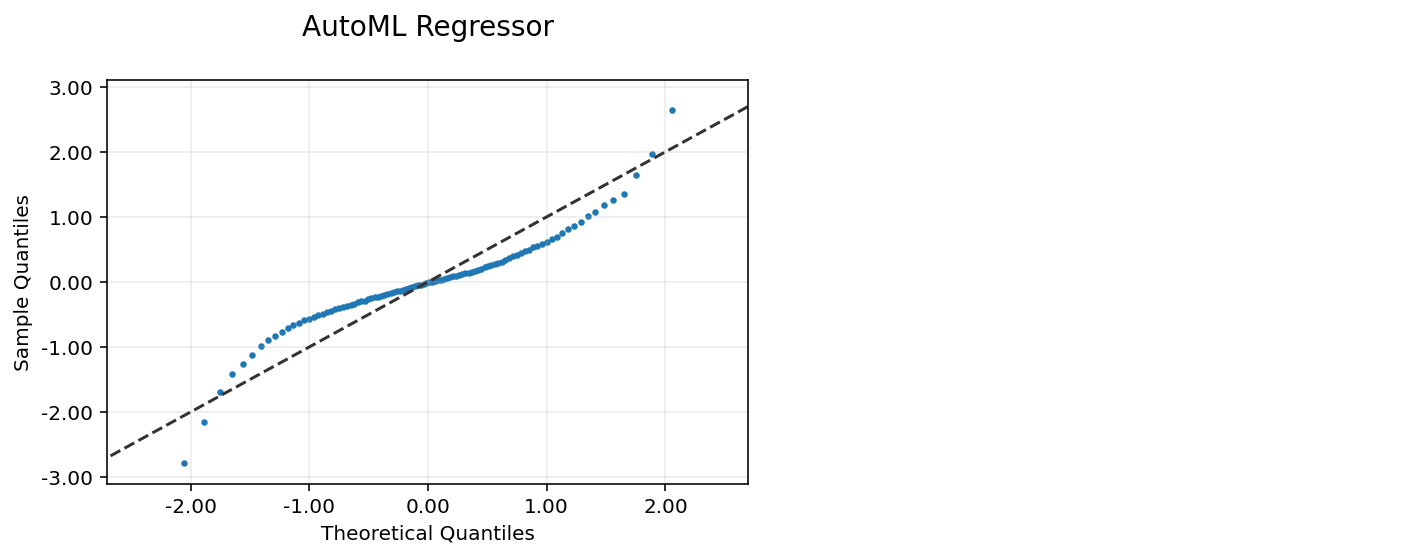

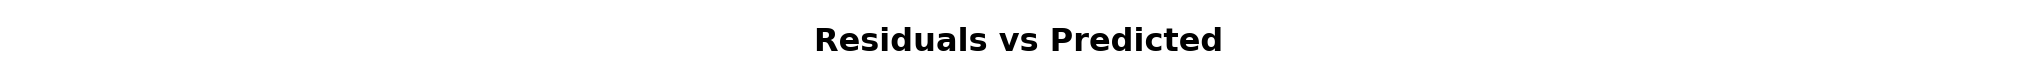

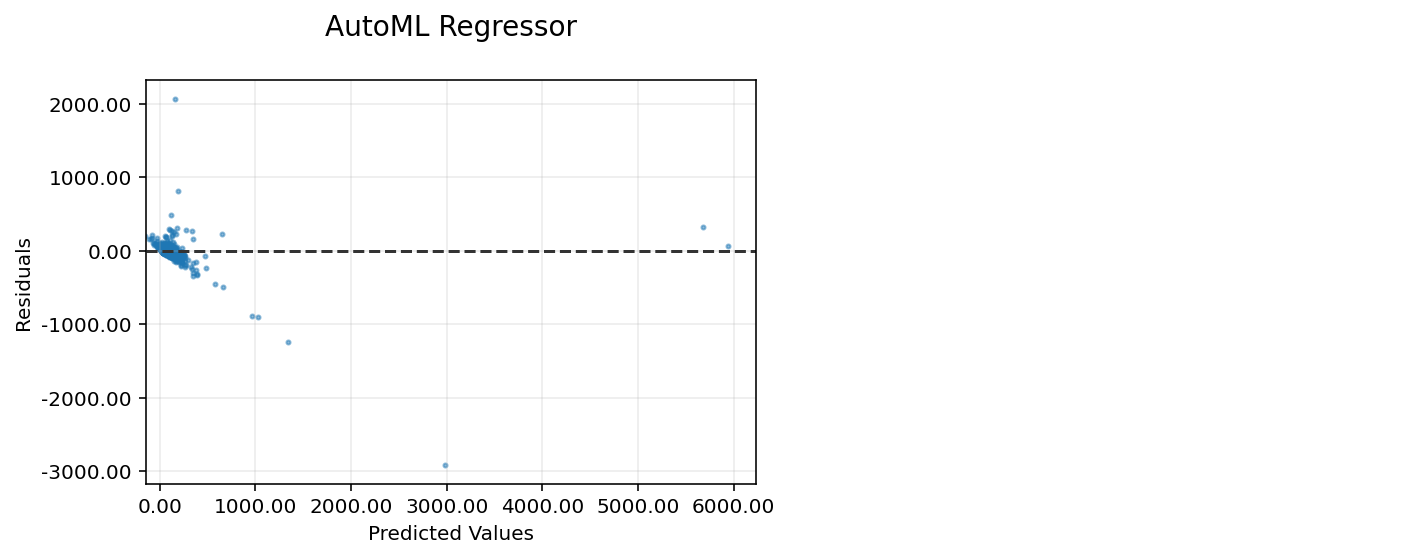

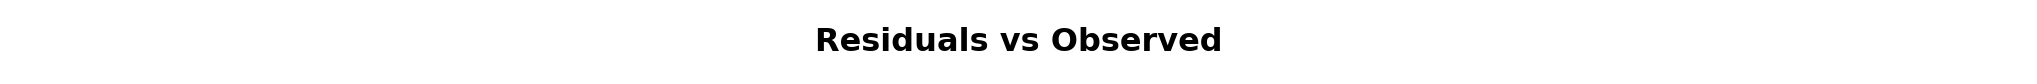

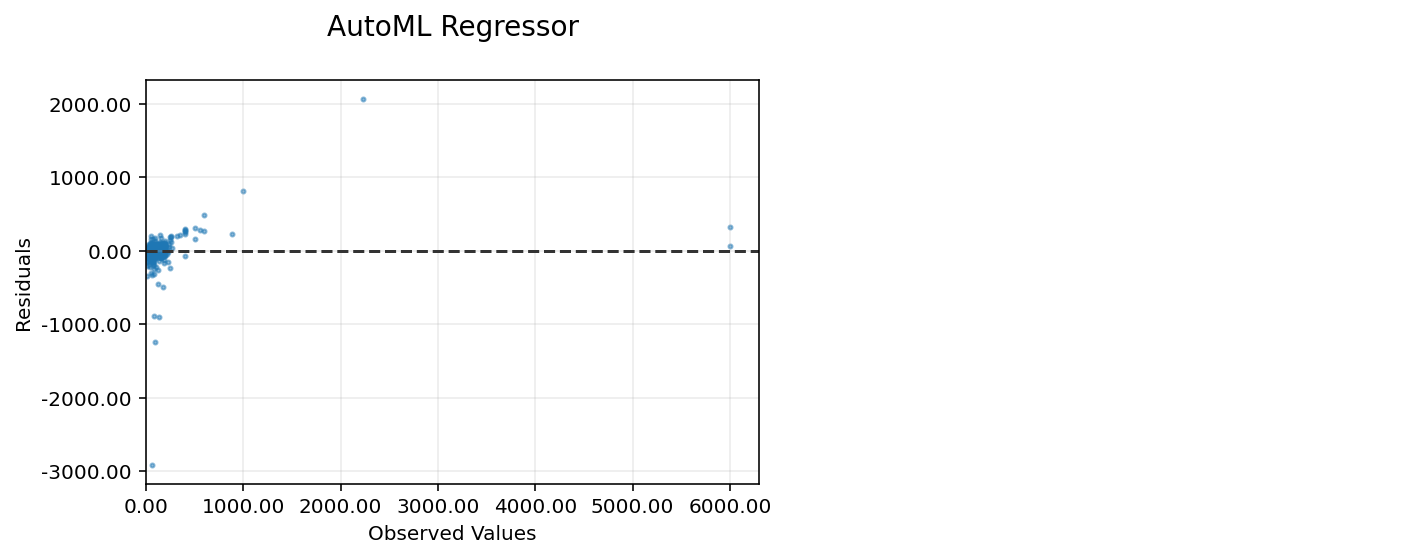

In [34]:
single_evaluator.show_in_notebook()

In [35]:
explainer = ADSExplainer(test, dt_model, training_data=train)
mlx.initjs()

In [36]:
pi_exp = PermutationImportance()
pi_exp.show_in_notebook()

#### Gráficos para avaliar como foi o processo automático de Amostragem Adaptativa, Seleção de Features e Ajuste de Hiperparâmetros

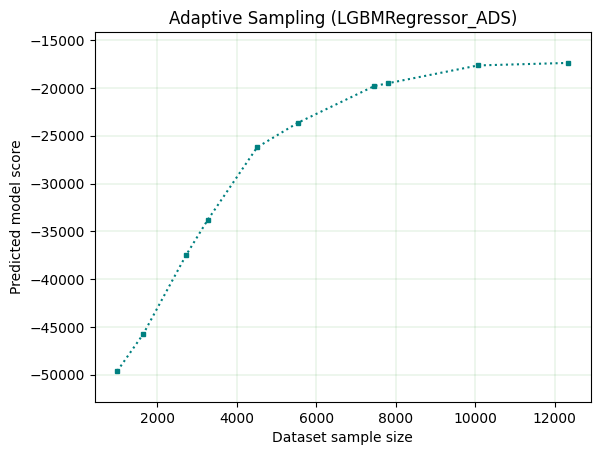

In [38]:
adap_sample(Est)

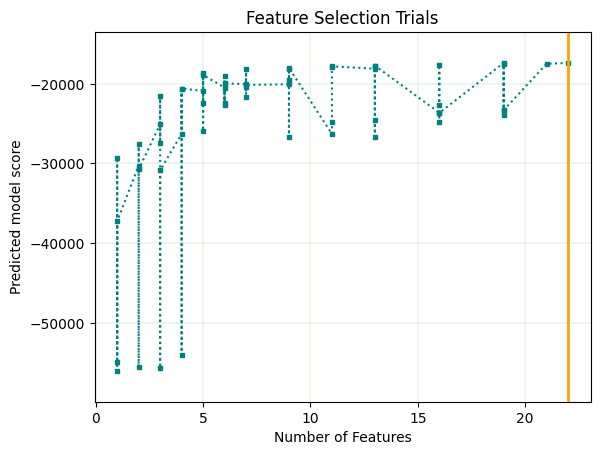

In [39]:
feat_selec(Est)

In [40]:
hyper_tuning(Est)

### Processo de MLOps

#### Salvando o modelo no Model Catalog

In [41]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ['PROJECT_OCID']

In [42]:
artifact_path = '/home/datascience/modelo'
artifact_model = automl_model.prepare(artifact_path, force_overwrite=True, 
                                     data_sample=test, data_science_env=True)

loop1:   0%|          | 0/5 [00:00<?, ?it/s]

[2022-05-09 13:09:26,837] [automl.interface] Execution engine (local) has already been initialized. Reinitializing!
INFO:xengine:All work stopped
INFO:xengine:All work stopped
[2022-05-09 13:09:27,046] [automl.xengine] Local ProcessPool execution (n_jobs=1)
[2022-05-09 13:09:27,047] [automl.xengine] Using Single Node XEngine with n_jobs: 1
[2022-05-09 13:09:27,051] [automl.xengine] Max timeout per task is set to 1500
[2022-05-09 13:09:27,055] [automl.xengine] local xengine initialization: <multiprocessing.pool.Pool object at 0x7f33940ee910>
Start loading model.pkl from model directory /home/datascience/modelo ...
Model is successfully loaded.
[2022-05-09 13:09:27,068] [automl.interface] Execution engine (local) has already been initialized. Reinitializing!
INFO:xengine:All work stopped
INFO:xengine:All work stopped
[2022-05-09 13:09:27,256] [automl.xengine] Local ProcessPool execution (n_jobs=1)
[2022-05-09 13:09:27,257] [automl.xengine] Using Single Node XEngine with n_jobs: 1
[2022-0

In [43]:
mc_model = artifact_model.save(project_id=project_id, compartment_id=compartment_id, 
                               display_name="Modelo_Preditor_Alugueis_Fast_Track_IV", 
                               description="Modelo Preditor Gerado pelo AutoML", 
                               ignore_pending_changes=True)

loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_77cf8f72-2e22-4602-ab2c-150292a45a72.zip


In [ ]:
model_id = mc_model.id
print(f"Model OCID: {model_id}")

#### Configuração da instância que receberá o modelo em produção

In [45]:
model_configuration_details_object = ModelConfigurationDetails(model_id=model_id,
                                                               instance_configuration=InstanceConfiguration(instance_shape_name='VM.Standard2.1'),
                                                               scaling_policy=FixedSizeScalingPolicy(instance_count=1),
                                                               bandwidth_mbps=20)

In [46]:
single_model_config = SingleModelDeploymentConfigurationDetails(deployment_type='SINGLE_MODEL',
                                                                model_configuration_details=model_configuration_details_object)

#### Criando grupo de logs para acompanhamento dos modelos em produção

In [ ]:
log_group_name = "ModelDeployment-Princing-HapVida"
access_log_name = "Access_Log"
predict_log_name = "Predict_Log"

log_group = OCILogGroup(display_name=log_group_name).create()
log_group_ocid = log_group.id
print(f"Log group OCID: {log_group_ocid}")

access_log = log_group.create_log(access_log_name)
access_log_ocid = access_log.id
print(f"Access log OCID: {access_log_ocid}")

# Create a predict log in the log group
predict_log = log_group.create_log(predict_log_name)
predict_log_ocid = predict_log.id
print(f"Predict log OCID: {predict_log_ocid}")

logs_configuration_details_object = CategoryLogDetails(access=LogDetails(log_group_id=log_group_ocid,
                                                                         log_id=access_log_ocid),
                                                       predict=LogDetails(log_group_id=log_group_ocid,
                                                                          log_id=predict_log_ocid))

#### Configurando os detalhes do modelo antes de colocá-lo em produção

In [48]:
model_deploy_configuration = CreateModelDeploymentDetails(display_name='Predicao de Alugueis',
                                                          description='Modelo de predicao de valores de alugueis diarios',
                                                          project_id=os.environ['PROJECT_OCID'],
                                                          compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'],
                                                          model_deployment_configuration_details=single_model_config,
                                                          category_log_details=logs_configuration_details_object
                                                         )

### Autenticação e aplicando as configurações para colocar o modelo em produção

In [49]:
auth = oci.auth.signers.get_resource_principals_signer()
data_science = DataScienceClient({}, signer=auth)
data_science_composite = DataScienceClientCompositeOperations(data_science)

### Este processo levará de 13 a 15 minutos, pois é aqui onde as instâncias são provisionadas e configuradas

In [50]:
%%time
# Creating a model deployment. This action takes a few minutes

deployer = data_science_composite.create_model_deployment_and_wait_for_state(
    model_deploy_configuration, 
    wait_for_states=["SUCCEEDED", "FAILED"]
)

CPU times: user 1.02 s, sys: 99.4 ms, total: 1.12 s
Wall time: 13min 10s


#### Obtendo a identificação do modelo em produção

In [ ]:
deployer = ModelDeployer()

for active in deployer.list_deployments(status="ACTIVE", compartment_id=compartment_id):
    deployment_id = active.properties.id
    print(active.properties.id)

In [68]:
deployer.list_deployments(status="ACTIVE", compartment_id=compartment_id)

### Preparando os acessos para enviar requisições para gerar previsões com o modelo criado e em produção

In [ ]:
deployment = deployer.get_model_deployment(model_deployment_id=deployment_id)
print(f"deployment OCID: {deployment.model_deployment_id}\n" +
      f"existing deployment OCID: {deployment.model_deployment_id}")

### Pegando um conjunto de informações para gerar previsão de vendas através do modelo em produção

In [65]:
pred = df_list_adjusted.to_pandas_dataframe()
pred = pred.drop(columns = ["PRICE"])

In [ ]:
deployment.predict(pred[513:514].to_json())

### Conjunto das variável para poder mudar os valores e solicitar a previsão do valor do aluguel diário

### ***Atenção: Alterar os valores que estão entre {"0":XX.X}, aqui representados pelos "X"!!!

In [ ]:
deployment.predict('{"AVAILABILITY_60":{"0":20.0},"AVAILABILITY_365":{"0":200.0},"NUMBER_OF_REVIEWS":{"0":200.0},"REVIEW_SCORES_RATING":{"0":97.0},"REQUIRES_LICENSE":{"0":0.0},"REQUIRE_GUEST_PROFILE_PICTURE":{"0":1.0},"REQUIRE_GUEST_PHONE_VERIFICATION":{"0":0.0},"CALCULATED_HOST_LISTINGS_COUNT":{"0":1.0},"REVIEWS_PER_MONTH":{"0":100.0},"HOST_IS_SUPERHOST":{"0":0.0},"HOST_TOTAL_LISTINGS_COUNT":{"0":3.0},"HOST_HAS_PROFILE_PIC":{"0":1.0},"HOST_IDENTITY_VERIFIED":{"0":1.0},"IS_LOCATION_EXACT":{"0":1.0},"BATHROOMS":{"0":1.0},"BEDROOMS":{"0":5.0},"BEDS":{"0":8.0},"CLEANING_FEE":{"0":0.0},"GUESTS_INCLUDED":{"0":1.0},"EXTRA_PEOPLE":{"0":20.0},"MINIMUM_NIGHTS":{"0":30.0},"MAXIMUM_NIGHTS":{"0":300.0}}')